## Human Resources Analytics. Why are our best and most experienced employees leaving prematurely?

*This is quite popular dataset available at  https://www.kaggle.com/ludobenistant/hr-analytics *

The goal of this study is:
1. make the best prediction
2. find the most influential parameters that affect the employee decision to leave
3. sort the list of employee based on the probability of them to leave the company, so the data is ready for HR to act upon


In [1]:
import pandas as pd
import numpy as np

In [2]:
filename = 'HR_comma_sep.csv'
data = pd.read_csv(filename)

In [3]:
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Here I need to make a decision on what to do with categorical data  (departments) - column 'sales', and ordinal data - column 'salary' (low, high, medium)

* Categorical is obvious - one hot encoding.
* For ordinal I used one hot encoding first but then switched it to encoding low-1, medium-2, high-3, therefore keeping an intuitive order. Apparently, doing it eather way produced similar prediction results.


In [4]:
departments = pd.get_dummies(data['sales'])

In [5]:
data = data.drop('sales', axis = 1)
data = data.join(departments)

In [6]:
print data

       satisfaction_level  last_evaluation  number_project  \
0                    0.38             0.53               2   
1                    0.80             0.86               5   
2                    0.11             0.88               7   
3                    0.72             0.87               5   
4                    0.37             0.52               2   
5                    0.41             0.50               2   
6                    0.10             0.77               6   
7                    0.92             0.85               5   
8                    0.89             1.00               5   
9                    0.42             0.53               2   
10                   0.45             0.54               2   
11                   0.11             0.81               6   
12                   0.84             0.92               4   
13                   0.41             0.55               2   
14                   0.36             0.56               2   
15      

In [7]:
set(data['salary'])

{'high', 'low', 'medium'}

In [8]:
data['salary'] = data['salary'].replace(to_replace='low', value=1)
data['salary'] = data['salary'].replace(to_replace='medium', value=2)
data['salary'] = data['salary'].replace(to_replace='high', value=3)

## It is time to extract the labels that'd be usded for predictive part

label 1 - means employee left
label 0 - employee stayed

In [9]:
Y = np.array(data['left'])
data = data.drop('left', axis = 1)

In [10]:
X = np.array(data)

In [11]:
len(Y) == np.shape(X)[0]

True

## Predictive Analytics

In [12]:
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cross_validation import train_test_split, KFold, cross_val_score, LeaveOneOut, StratifiedKFold
from sklearn import metrics, preprocessing, cross_validation
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.decomposition import PCA, RandomizedPCA, FastICA, KernelPCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import sem
from sklearn.learning_curve import learning_curve

/Users/olgaatmac/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/olgaatmac/anaconda/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


## Helpers functions

In [13]:
def measure_performance(X,y,clf, show_accuracy = True, show_classification_report = True, show_confusion_matrix = True):
    y_pred = clf.predict(X)
    if show_accuracy:
        print "Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n"
    if show_classification_report:
        print "Classification report"
        print metrics.classification_report(y,y_pred),"\n"
    if show_confusion_matrix:
        print "Confusion matrix:"
        print metrics.confusion_matrix(y,y_pred),"\n"

In [14]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a plot of the test and traning learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [15]:
print np.shape(X)
print np.shape(Y)

(14999, 18)
(14999,)


## Splitting data on training and testing. 

*Strictly speaking it has to be three groups: training, testing, validation. I decided to go with simplified version to see the results first. If I am unhappy with 2 group I would change it to 3. Another concern was that in terms of labels the data is disproportional. There are more people that stayed than left. I did not want the algorithm to run thin on label 1*


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 33)

In [17]:
np.shape(X_train)

(11249, 18)

In [18]:
np.shape(X_test)[0]/float(np.shape(X)[0])

0.25001666777785186

## Run different classifiers to compare the prediction power. Also, watch the learning curves.

*the best by far is RandomForest (accuracy 0.986). I will stick to it.*
I played with KNN a bit to see the optimal number of neighbors. And also with SCV to ajust C. 

Check the learning curves for DecisionTree vs RandomForest. See the gap in DT training and testing? The algorithm is not generalizing well enough. It would probably do well if we have more data, but no worries - RandomForest fixes the problem

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy:0.959 

Classification report
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      2836
          1       0.91      0.92      0.92       914

avg / total       0.96      0.96      0.96      3750


Confusion matrix:
[[2755   81]
 [  74  840]] 



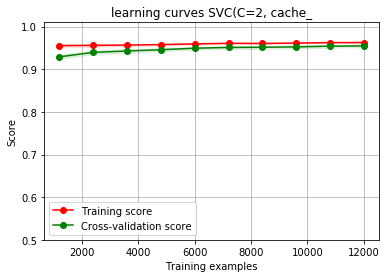

------------------------------------------------------
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=30,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Accuracy:0.977 

Classification report
             precision    recall  f1-score   support

          0       0.99      0.98      0.98      2836
          1       0.94      0.96      0.95       914

avg / total       0.98      0.98      0.98      3750


Confusion matrix:
[[2784   52]
 [  34  880]] 



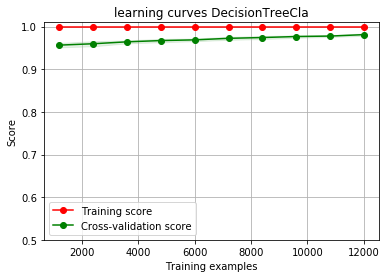

------------------------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=33,
            verbose=0, warm_start=False)

Accuracy:0.986 

Classification report
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      2836
          1       1.00      0.95      0.97       914

avg / total       0.99      0.99      0.99      3750


Confusion matrix:
[[2833    3]
 [  48  866]] 



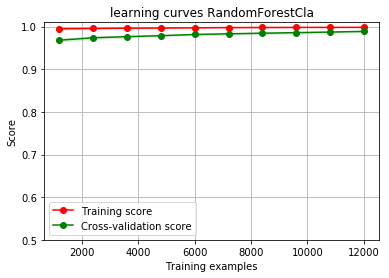

------------------------------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Accuracy:0.938 

Classification report
             precision    recall  f1-score   support

          0       0.97      0.95      0.96      2836
          1       0.84      0.92      0.88       914

avg / total       0.94      0.94      0.94      3750


Confusion matrix:
[[2681  155]
 [  77  837]] 



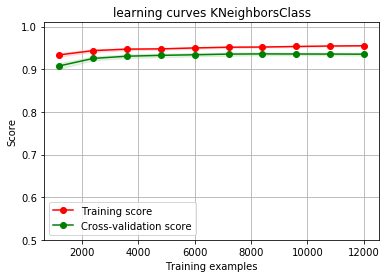

------------------------------------------------------
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

Accuracy:0.963 

Classification report
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      2836
          1       0.93      0.92      0.92       914

avg / total       0.96      0.96      0.96      3750


Confusion matrix:
[[2772   64]
 [  76  838]] 



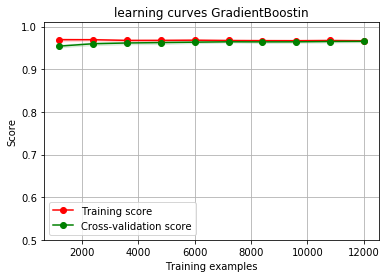

------------------------------------------------------


In [19]:
# to run SVM, kNN, Booster, DT CLASSIFIERS :
#---------------------------------

clfSVC = SVC(C = 2)
#clfSVC_linear = SVC(kernel='linear')
clfDT = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 30, min_samples_leaf = 1)
clfRF = RandomForestClassifier(n_estimators = 10, random_state =33) 
clfKNN = KNeighborsClassifier(n_neighbors=5)
clfGB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)

classifiers = [clfSVC,clfDT,clfRF,clfKNN,clfGB]

X, y = X, Y
cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)

for clf in classifiers:
    clf = clf.fit(X_train,y_train)
    
    print str(clf)
    print
    measure_performance(X_test, y_test,clf)
   
    title = "learning curves " + str(clf)[0:15]
    plot_learning_curve(clf, title, X, y, (0.5, 1.01), cv=cv, n_jobs=1)

    plt.show()
    print "------------------------------------------------------"

In [20]:
clf = clfRF.fit(X_train,y_train)

## Calulating probabilities from RandomForest results. Insert them as a culumn in dataframe and sort

In [21]:
proba = clf.predict_proba(X)
probability = proba[:,1]      

In [22]:
data['probability']= probability
data.keys()

Index([u'satisfaction_level', u'last_evaluation', u'number_project',
       u'average_montly_hours', u'time_spend_company', u'Work_accident',
       u'promotion_last_5years', u'salary', u'IT', u'RandD', u'accounting',
       u'hr', u'management', u'marketing', u'product_mng', u'sales',
       u'support', u'technical', u'probability'],
      dtype='object')

In [23]:
data.sort_values('probability')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,probability
7499,0.93,0.58,5,238,2,0,0,2,0,0,0,0,0,0,0,1,0,0,0.0
8173,0.79,0.99,4,183,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0.0
8174,0.63,0.85,5,214,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0.0
8175,0.68,0.48,5,113,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0.0
8176,0.74,0.69,4,244,2,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0
8177,0.49,0.67,6,286,4,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0
8179,0.90,0.91,5,176,3,0,0,2,0,0,0,0,0,0,0,1,0,0,0.0
8180,0.70,0.67,5,136,3,0,0,2,0,0,0,0,0,0,0,1,0,0,0.0
8181,0.84,0.71,4,222,2,0,0,2,0,0,0,0,0,0,0,1,0,0,0.0
8182,0.89,0.77,4,269,4,0,0,2,0,0,0,0,0,0,0,1,0,0,0.0


## Looking at the most important factors.
Surprise! it is not a salary! it is a satisfaction level (whatever it means)

In [24]:
importances = clf.feature_importances_

Feature ranking:

satisfaction_level 0.2962141386

last_evaluation 0.203969028224

number_project 0.186905048536

average_montly_hours 0.149889316339

time_spend_company 0.117238528797

Work_accident 0.0130298641281

promotion_last_5years 0.0105823840589

salary 0.00359553337644

IT 0.00333374892957

RandD 0.00282353311169

accounting 0.00215996058648

hr 0.00212957195096

management 0.00166394553284

marketing 0.00166353529491

product_mng 0.00158023452729

sales 0.00133235697969

support 0.00131719635469

technical 0.000572074671372


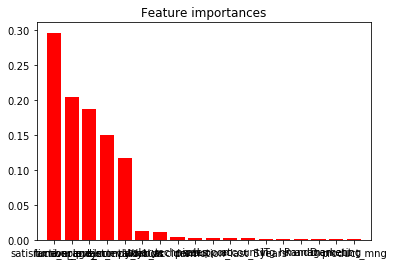

In [25]:
std = np.std([clf.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
importances_names = data.columns[indices]
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print
    print data.columns[f], importances[indices[f]]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), importances_names)
plt.xlim([-1, X.shape[1]])
plt.show()

Satisfaction level is important, but... let's look at the hystogram. ON the left one are those who would probably stay.On the right one - those who would probably leave. Apparantly there is no direct answer. Playing with bin size my shed some light. 

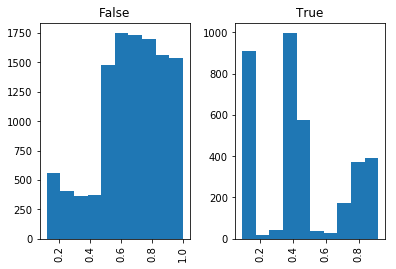

In [26]:
data['satisfaction_level'].hist(by=(data['probability']>=0.5))
plt.show()